## Croatian daily streamflow data download and pre-processing:

#### The main objective of this script is to download and pre-process  the available streamflow data from the Croatian official authority and have a close look at their gaps. The official data is well organizaed, but the data is not easily available for download, so python is needed. 

Written by: Thiago Victor Medeiros do Nascimento

References:

1. Hydroportal: https://hidro.dhz.hr/

In [21]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
from plotly.offline import plot
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import datetime
import tqdm as tqdm
import os
import glob
warnings.simplefilter(action='ignore', category=Warning)
import geospatialfunctions as geospatialfunctions

%config Completer.use_jedi = False # This improve the auto-fill function

In [3]:
path = r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Datasets"
os.chdir(path)
os.getcwd()

'C:\\Users\\nascimth\\Documents\\Thiago\\Eawag\\Python\\Datasets'

In [4]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import html5lib

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC

In [5]:
# import Action chains 
from selenium.webdriver.common.action_chains import ActionChains
import time

### Croatia does not provide one simple way to download all data at once, hence we can work with selenium to automatize the process:

#### 1. Data download:

1. First we need to have a look at the dataset and select with a filter select the list of stations to be downloaded.

This list was obtained manually from the website:

In [5]:
list_stations = pd.read_csv(r'Croatia\original\list_order.txt', header = None)
list_stations = list_stations[0]
list_stations

0        6
1        7
2        8
3        9
4       10
      ... 
178    384
179    388
180    395
181    396
182    397
Name: 0, Length: 183, dtype: int64

In [73]:
URL = "https://hidro.dhz.hr"
driver = webdriver.Chrome()

path = URL
# First we get the URL:
driver.get(path)

driver.implicitly_wait(10)

# Here we click to switch to the data information:
driver.find_element_by_xpath('//*[@id="ext-gen139"]/em/span/span/span').click()

# Here we click on the storic data part:
button = driver.find_element_by_xpath("/html/body/div[1]/div/div/div[2]/div[1]/div[1]/ul/li[3]/a[2]/em/span/span")
driver.execute_script("arguments[0].click();", button)

# Here we accept the terms:
button = driver.find_element_by_xpath("/html/body/div[8]/div[2]/div[2]/div/div/div/div[1]/table/tbody/tr/td[2]/table/tbody/tr/td[1]/table/tbody/tr/td/table/tbody/tr[2]/td[2]/em/button")
driver.execute_script("arguments[0].click();", button)

# Select the station:
driver.find_element_by_xpath('//*[@id="ext-gen239"]/div[6]').click()

# Here we click to switch to streamflow (m3/s). We should click here just once:
driver.find_element_by_xpath('//*[@id="prik_tippod"]').click()

##############################################################
# Here you expand the table:
button = driver.find_element_by_xpath('//*[@id="ext-gen355"]')
driver.execute_script("arguments[0].click();", button)

# It is always safe to increase the implicity waiting time:
driver.implicitly_wait(5)


time.sleep(5) # It is important to insert this sleep time, otherwise we would not have everything refreshed before start:
# Without this sleep function we were often having some errors.
xpath_i = '//*[@id="ext-gen239"]/div[number]'

stations_names = pd.DataFrame(index = range(len(list_stations)), columns = ["name", "code", "num"])
z = 0

#Here we can first save each station infromation (name and code)
for station in tqdm.tqdm(list_stations):
    xpath = xpath_i.replace("number", str(station))
    time.sleep(5)
    driver.find_element_by_xpath(xpath).click()
    stations_names.iloc[z, 0] = namedf[0]
    
    xpathname_i = '//*[@id="ext-gen239"]/div[number_name]/table'
    xpathname = xpathname_i.replace("number_name", str(station))
    
    name = driver.find_element_by_xpath(xpathname).get_attribute('outerHTML')
    namedf  = pd.read_html(name)

    stations_names.iloc[z, 0:2] = namedf[0]
    stations_names.iloc[z, 2] = station
    
    
    z = z + 1
    

100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [15:39<00:00,  5.14s/it]


In [69]:
#stations_names.to_excel(r'Croatia\original\stations_namesk.xlsx')

2. Here we can generate the list of the years for each station.

The years available were ontained manuyally since this part of the website was not available via selenium.

In [27]:
network_HR = pd.read_excel(r'Croatia\original\stations_names_description.xlsx')
network_HR 

,name,code,num,Area (km2),Initial1,Final1,Initial2,Final2,Initial3,Final3,Initial4,Final4
0,"ŠIPAK, BAĆINSKA JEZERA",7136,6,NaN,1973,2021,NaN,NaN,NaN,NaN,NaN,NaN
1,"KOSINJSKI BAKOVAC, BAKOVAC",8031,7,NaN,1981,2021,NaN,NaN,NaN,NaN,NaN,NaN
2,"ŠPORČIĆ KLANAC, BAKOVAC",8056,8,NaN,1980,2017,2019.0,2020.0,NaN,NaN,NaN,NaN
3,"KLJUČ, BEDNJA",5143,9,415670.0,1987,2021,NaN,NaN,NaN,NaN,NaN,NaN
4,"LEPOGLAVA, BEDNJA",5140,10,89800.0,1987,2021,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
154,"BOŽJAKOVINA, ZELINA",3367,383,186000.0,1991,2021,NaN,NaN,NaN,NaN,NaN,NaN
155,"ERVENIK, ZRMANJA",7253,384,214000.0,1951,1991,1997.0,2021.0,NaN,NaN,NaN,NaN
156,"ŽDALA, ŽDALICA",5144,395,NaN,1988,2021,NaN,NaN,NaN,NaN,NaN,NaN
157,"IZVOR ŽRNOVNICE, ŽRNOVNICA",7299,396,NaN,1989,2021,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
i = 0
listall = []

for stations in network_HR.code:
    list1 = range(int(network_HR.iloc[i, 4]), int(network_HR.iloc[i, 5]) + 1)
    list1 = [*list1]
    
    try:
        list2 = range(int(network_HR.iloc[i, 6]), int(network_HR.iloc[i, 7]) + 1)
        list2 = [*list2]
    except:
        list2 = []    
    
    try:
        list3 = range(int(network_HR.iloc[i, 8]), int(network_HR.iloc[i, 9]) + 1)
        list3 = [*list3]
    except:
        list3 = []     
    
    try:
        list4 = range(int(network_HR.iloc[i, 10]), int(network_HR.iloc[i, 11]) + 1)
        list4 = [*list4]
    except:
        list4 = []  
        
    listfinal = list1 + list2 + list3 + list4
    
    # List all is a list of lists with the range of years avaialble for each station:
    listall.append(listfinal)
    
    i = i + 1

3. At this part we can download the data for each station and save the time-series:

In [31]:
URL = "https://hidro.dhz.hr"
driver = webdriver.Chrome()

path = URL
# First we get the URL:
driver.get(path)

driver.implicitly_wait(10)

# Here we click to switch to the data information:
driver.find_element_by_xpath('//*[@id="ext-gen139"]/em/span/span/span').click()

# Here we click on the storic data part:
button = driver.find_element_by_xpath("/html/body/div[1]/div/div/div[2]/div[1]/div[1]/ul/li[3]/a[2]/em/span/span")
driver.execute_script("arguments[0].click();", button)

# Here we accept the terms:
button = driver.find_element_by_xpath("/html/body/div[8]/div[2]/div[2]/div/div/div/div[1]/table/tbody/tr/td[2]/table/tbody/tr/td[1]/table/tbody/tr/td/table/tbody/tr[2]/td[2]/em/button")
driver.execute_script("arguments[0].click();", button)

# Select the station:
driver.find_element_by_xpath('//*[@id="ext-gen239"]/div[7]').click()

# Here we click to switch to streamflow (m3/s). We should click here just once:
driver.find_element_by_xpath('//*[@id="prik_tippod"]').click()

##############################################################
# Here we can select the year:

# Here you expand the table:
button = driver.find_element_by_xpath('//*[@id="ext-gen355"]')
driver.execute_script("arguments[0].click();", button)

# It is always safe to increase the implicity waiting time:
driver.implicitly_wait(10)

# Here we have a loop to retrieve data for each year:

time.sleep(1) # It is important to insert this sleep time, otherwise we would not have everything refreshed before start:
# Without this sleep function we were often having some errors.

xpath_i = '//*[@id="ext-gen239"]/div[number]' #This is the path where you can insert the number of station

# Here we can make a list with the years:
#years = list(range(1981, 2022))
#years.reverse()

#This loop os made for retriving data for each station:
z = 75

# We first create a n empty dataframe to fill with our data:
timeseriesfinal = pd.DataFrame(index = pd.date_range('01-01-1950','12-31-2022', freq='D'))

for station in tqdm.tqdm(network_HR.num[75:100]):
   
    # Here we can create an empty dataframe to be filled:
    dados_full = pd.DataFrame() 
    # Here we get the name of the station:
    
    namestation = network_HR.iloc[z, 1]
    
    #Here you insert the number of the station on the path:
    xpath = xpath_i.replace("number", str(station))
    
    time.sleep(2)
    # Now we select our station:
    driver.find_element_by_xpath(xpath).click()
    
    
    # Here we can take the list with the years:
    years = listall[z].copy()
    years.reverse()
    
    z = z + 1
    
    time.sleep(2)
    for ano in years:
        
        time.sleep(2)
        # This was the only way to change from year to year:
    
        # get element 
        element = driver.find_element_by_xpath('//*[@id="izbgod_b1"]')  
        # create action chain object
        action = ActionChains(driver)
        # click the item
        action.click(on_element = element)
        # perform the operation
        action.perform()
    
        # Here you can retrieve the data for each year:
        tbl = driver.find_element_by_xpath('//*[@id="ext-gen331"]').get_attribute('outerHTML')
        df  = pd.read_html(tbl, decimal=',', thousands='.')
        dados_pluv = pd.DataFrame(index = range(len(df)), columns = [0,1])
    
        # However we also need to do a lopp to get each line of the dataset:
        for i in range(len(df)):
            dados_pluv.iloc[i, :] = df[i]
    
        # Here we can insert the dates:
        dados_pluv["dates"] = dados_pluv[0].astype(str) + str(ano)
        dados_pluv["dates"] = dados_pluv["dates"].astype(str)
        dados_pluv["dates"].replace({'00:00': ''}, regex=True, inplace=True)
        dados_pluv["dates"].replace({' ': ''}, regex=True, inplace=True)

        dados_full = dados_full.append(dados_pluv, ignore_index = True)
        
        
    # Here we can adjust our dataset:
    dados_full.drop(0, axis = 1, inplace = True)
    dados_full["dates"] = pd.to_datetime(dados_full['dates'], format='%d.%m.%Y')
    dados_full.columns = ["Qm3_s", "dates"]
    dados_full.set_index("dates", inplace = True)
    dados_full.replace('---', np.nan, inplace = True)
    dados_full = dados_full.astype(float)
        
    timeseriesfinal.loc[:, int(namestation)] = dados_full.Qm3_s

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [1:04:20<00:00, 154.43s/it]


In [32]:
timeseriesfinal_1 = timeseriesfinal.copy()
timeseriesfinal_1.to_excel(r'Croatia\timeseriesfinal_75_100.xlsx')

#### 2. Data organization:

In [8]:
# Data lecture
path =r'Croatia\original\data'
filenames = glob.glob(path + "/*.xlsx")
filenames

['Croatia\\original\\data\\timeseriesfinal_00.xlsx',
 'Croatia\\original\\data\\timeseriesfinal_01.xlsx',
 'Croatia\\original\\data\\timeseriesfinal_02.xlsx',
 'Croatia\\original\\data\\timeseriesfinal_03.xlsx',
 'Croatia\\original\\data\\timeseriesfinal_04.xlsx',
 'Croatia\\original\\data\\timeseriesfinal_05.xlsx',
 'Croatia\\original\\data\\timeseriesfinal_06.xlsx']

In [15]:
tsdf = pd.read_excel(filename, index_col=0)
tsdf.index = pd.to_datetime(tsdf.index, format='%Y-%m-%d')

In [17]:
i = 0
for filename in tqdm.tqdm(filenames):
    
    tsdf = pd.read_excel(filename, index_col=0)
    tsdf.index = pd.to_datetime(tsdf.index, format='%Y-%m-%d')

    timeseries = pd.DataFrame(index = pd.date_range('01-01-1950','12-31-2022', freq='D'), data = tsdf.astype('float'))
    
    # Now the concatatanion is made, and at the end we might have the total of streamflow gauges as columns:
    if i == 0:
        timeseriesfinal = timeseries
    else:
        timeseriesfinal = pd.concat([timeseriesfinal, timeseries], axis=1)
    i = i + 1
        

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:42<00:00,  6.05s/it]


In [18]:
timeseriesfinal

,7136,8031,8056,5143,5140,5089,5065,5075,3352,3171,...,3125,7033,5091,5134,3234,3367,7253,5144,7299,7249
1950-01-01,NaN,NaN,NaN,NaN,NaN,1.124,NaN,NaN,NaN,0.547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-02,NaN,NaN,NaN,NaN,NaN,1.124,NaN,NaN,NaN,0.492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-03,NaN,NaN,NaN,NaN,NaN,1.708,NaN,NaN,NaN,0.371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-04,NaN,NaN,NaN,NaN,NaN,1.397,NaN,NaN,NaN,0.350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-05,NaN,NaN,NaN,NaN,NaN,1.397,NaN,NaN,NaN,0.371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#timeseriesfinal.to_excel(r'Croatia\timeseries_HR.xlsx')

In [31]:
timeseries_HR = timeseriesfinal.copy()

Here we can read the time-series:

In [34]:
timeseries_HR = pd.read_excel(r'Croatia\timeseries\timeseries_HR.xlsx', index_col=0)
timeseries_HR.columns = timeseries_HR.columns.astype(str)
timeseries_HR

,7136,8031,8056,5143,5140,5089,5065,5075,3352,3171,...,3125,7033,5091,5134,3234,3367,7253,5144,7299,7249
1950-01-01,NaN,NaN,NaN,NaN,NaN,1.124,NaN,NaN,NaN,0.547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-02,NaN,NaN,NaN,NaN,NaN,1.124,NaN,NaN,NaN,0.492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-03,NaN,NaN,NaN,NaN,NaN,1.708,NaN,NaN,NaN,0.371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-04,NaN,NaN,NaN,NaN,NaN,1.397,NaN,NaN,NaN,0.350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-05,NaN,NaN,NaN,NaN,NaN,1.397,NaN,NaN,NaN,0.371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we can read the network information:

In [47]:
network_HR = pd.read_excel(r'Croatia\timeseries\network_HR.xlsx')
network_HR.code = network_HR.code.astype(str)
network_HR 

,name,code,num,Area (km2),Lon,Lat
0,"ŠIPAK, BAĆINSKA JEZERA",7136,6,NaN,17.423868,43.069136
1,"KOSINJSKI BAKOVAC, BAKOVAC",8031,7,NaN,15.211571,44.710665
2,"ŠPORČIĆ KLANAC, BAKOVAC",8056,8,NaN,15.233977,44.703883
3,"KLJUČ, BEDNJA",5143,9,415.67,16.378201,46.179840
4,"LEPOGLAVA, BEDNJA",5140,10,89.80,16.033129,46.206730
...,...,...,...,...,...,...
154,"BOŽJAKOVINA, ZELINA",3367,383,186.00,16.284426,45.818834
155,"ERVENIK, ZRMANJA",7253,384,214.00,15.939828,44.107690
156,"ŽDALA, ŽDALICA",5144,395,NaN,17.161000,46.155311
157,"IZVOR ŽRNOVNICE, ŽRNOVNICA",7299,396,NaN,16.573901,43.522881


3. Now we start the data analysis:

In [48]:
network_HR.drop(["num"], axis = 1, inplace = True)
names = ['Name', 'Code', 'Area', 'xcoord', 'ycoord']
network_HR.columns = names


coords = network_HR[["xcoord", "ycoord", "Code", "Area"]]
coords.set_index('Code', inplace = True)

coords.xcoord.astype(float)
coords.ycoord.astype(float)

coords

,xcoord,ycoord,Area
Code,,,
7136,17.423868,43.069136,NaN
8031,15.211571,44.710665,NaN
8056,15.233977,44.703883,NaN
5143,16.378201,46.179840,415.67
5140,16.033129,46.206730,89.80
...,...,...,...
3367,16.284426,45.818834,186.00
7253,15.939828,44.107690,214.00
5144,17.161000,46.155311,NaN


(<Figure size 1080x2160 with 1 Axes>, <AxesSubplot:>)

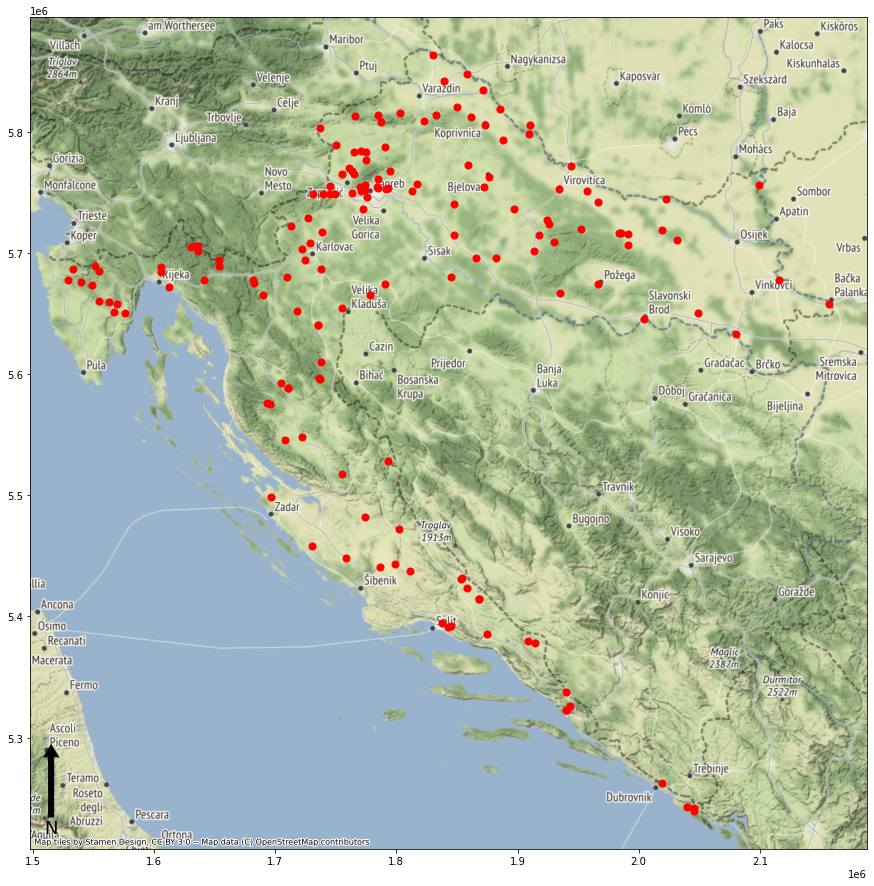

In [30]:
geospatialfunctions.plotpointsmap(coords, colorpoints= "red", markersize_map=50)

In [50]:
summarygapsstations = geospatialfunctions.summarygaps(timeseries_HR.loc["1981":"2022",:], coords)
summarygapsstations["area"] = coords["Area"]

summarygapsstations

,CoordX,CoordY,NumGaps,PercentageGaps,area
Code,,,,,
7136,17.423868,43.069136,365.0,2.379400,NaN
8031,15.211571,44.710665,365.0,2.379400,NaN
8056,15.233977,44.703883,1193.0,7.777053,NaN
5143,16.378201,46.179840,3061.0,19.954368,415.67
5140,16.033129,46.206730,2556.0,16.662321,89.80
...,...,...,...,...,...
3367,16.284426,45.818834,4164.0,27.144720,186.00
7253,15.939828,44.107690,3114.0,20.299870,214.00
5144,17.161000,46.155311,3140.0,20.469361,NaN


<AxesSubplot:xlabel='Code'>

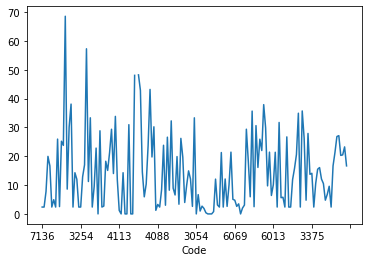

In [39]:
summarygapsstations.PercentageGaps.plot()

(<Figure size 1080x2160 with 2 Axes>, <AxesSubplot:>)

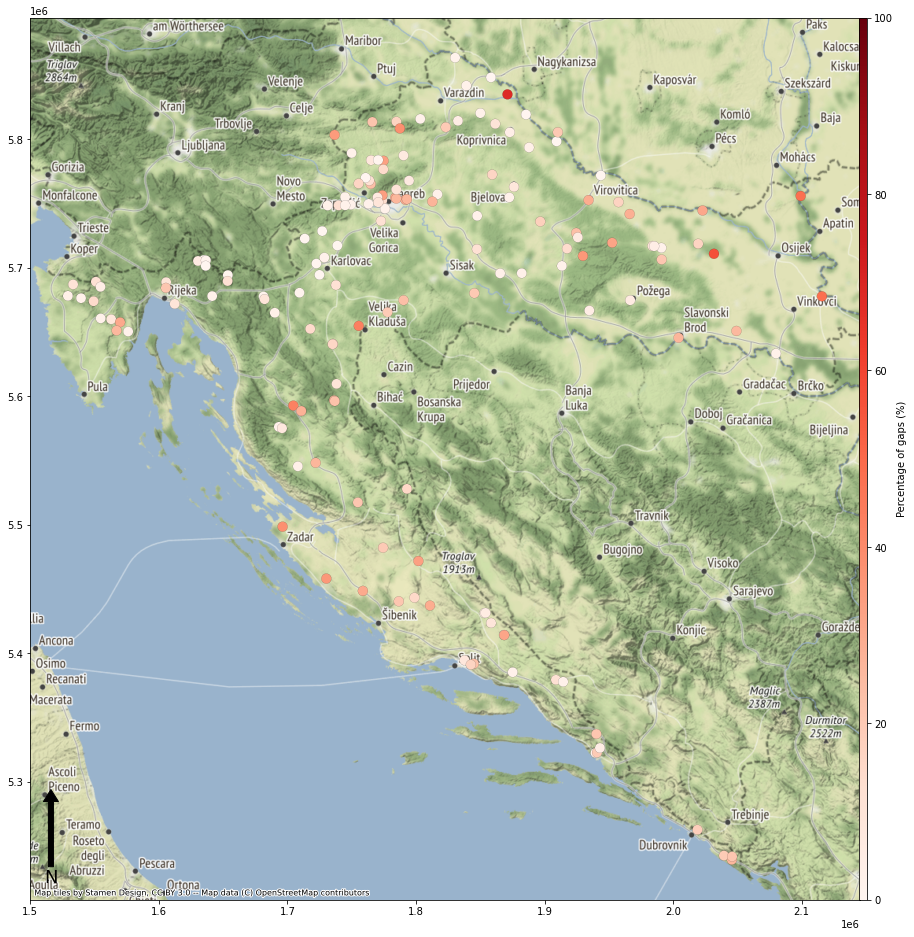

In [40]:
geospatialfunctions.plotgapsmap(summarygapsstations = summarygapsstations, crsproj = 'epsg:4326', backmapproj = True, 
                             figsizeproj = (15, 30), cmapproj = "Reds", markersize_map = 100)

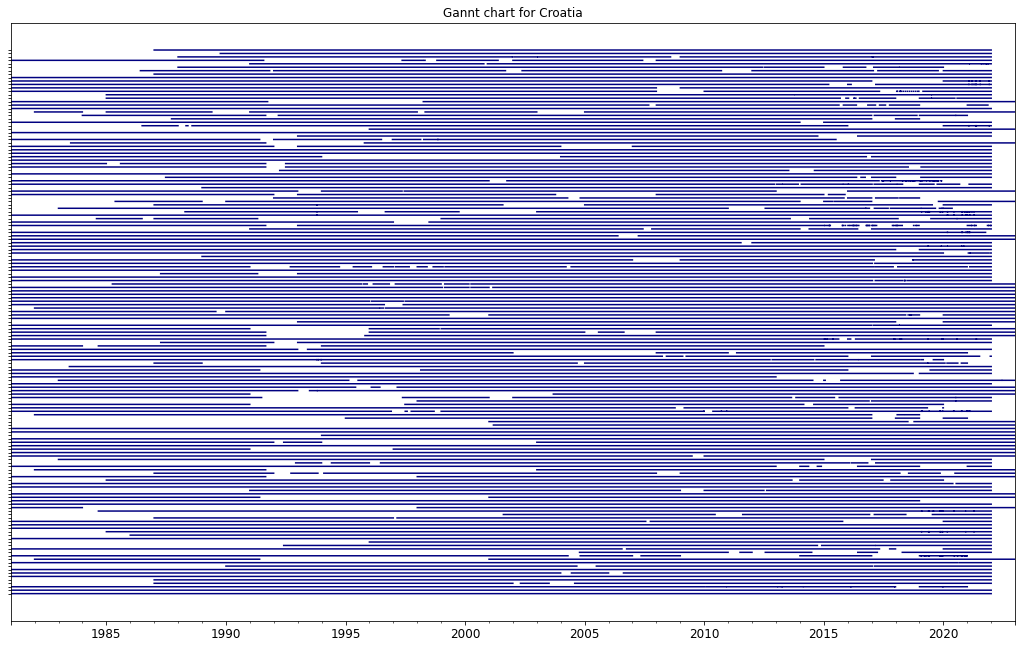

In [23]:
figplot, axesplot = geospatialfunctions.plotganntchart(timeseriesfinal_gantt = timeseriesfinal.loc["1981":"2022",:], figsize_chart = (18, 11), 
                                   showcodes = False,
                                   color_chart = "navy", fontsize_chart = 12,facecolor_chart = "white", 
                                   title_chart = "Gannt chart for Croatia")

In [45]:
idcondition = summarygapsstations[summarygapsstations.PercentageGaps < 50].index.tolist()

timeseriesfinalcondition = timeseries_HR.loc[:, idcondition]
timeseriesfinalcondition

,7136,8031,8056,5143,5140,5089,5065,5075,3352,3171,...,3125,7033,5091,5134,3234,3367,7253,5144,7299,7249
1950-01-01,NaN,NaN,NaN,NaN,NaN,1.124,NaN,NaN,NaN,0.547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-02,NaN,NaN,NaN,NaN,NaN,1.124,NaN,NaN,NaN,0.492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-03,NaN,NaN,NaN,NaN,NaN,1.708,NaN,NaN,NaN,0.371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-04,NaN,NaN,NaN,NaN,NaN,1.397,NaN,NaN,NaN,0.350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-05,NaN,NaN,NaN,NaN,NaN,1.397,NaN,NaN,NaN,0.371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
#network_HR_50 = summarygapsstations[summarygapsstations.PercentageGaps < 50.0]
#network_HR_50.to_excel(r'GIS\Catchments\Croatia\network_HR_50.xlsx') 

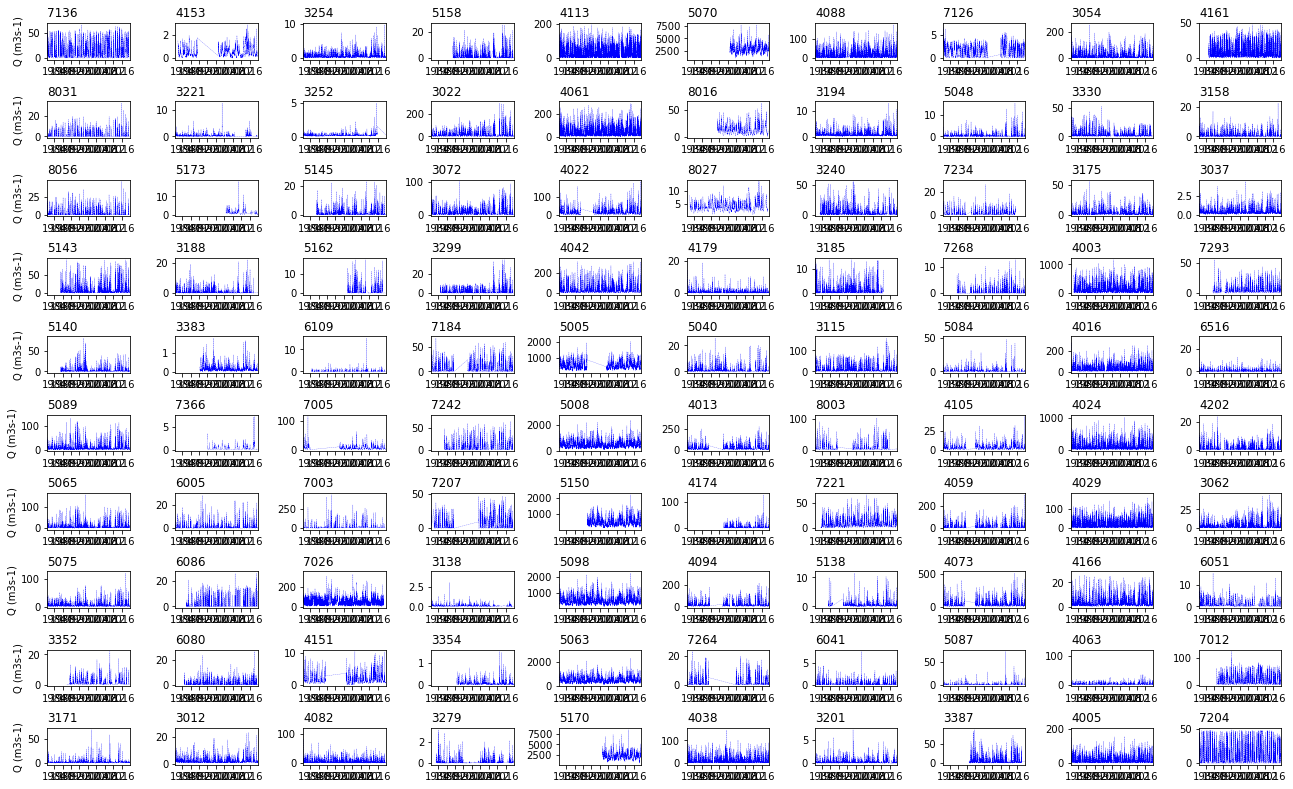

In [52]:
figplot, axesplot = geospatialfunctions.plottimeseries(numr = 10, numc = 10, datatoplot = timeseries_HR.iloc[:, 0:100], setylim = False, ymin = 0, ymax = 1, figsizeproj = (18, 11),
                   colorgraph = "blue", linewidthproj = 0.2, linestyleproj = "-.",  ylabelplot = "Q (m3s-1)",
                   datestart = datetime.date(1980, 10, 1), dateend = datetime.date(2022, 9, 30),
                   setnumberofintervals = False, numberintervals = 2)